In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import pickle

In [60]:
path='Downloads/dataset/'
movies=pd.read_csv(path+'movies.csv')
tags=pd.read_csv(path+'tags.csv')
ratings=pd.read_csv(path+'ratings.csv')

In [61]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [62]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [63]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [64]:
movies['genres']=movies['genres'].str.replace('|',' ')

<ipython-input-64-53f782c7a614>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  movies['genres']=movies['genres'].str.replace('|',' ')


In [65]:
len(movies.movieId.unique())

9742

In [66]:
len(ratings.movieId.unique())

9724

In [67]:
ratings_f=ratings.groupby('userId').filter(lambda x: len(x) >=55)
movie_list_rating=ratings_f.movieId.unique().tolist()

In [68]:
len(ratings_f.movieId.unique())/len(movies.movieId.unique())*100

98.7990145760624

In [69]:
len(ratings_f.userId.unique())/len(ratings.userId.unique())*100

59.67213114754099

In [70]:
movies=movies[movies.movieId.isin(movie_list_rating)]

In [71]:
movies.head(3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance


In [72]:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [73]:
tags.drop(['timestamp'] ,1, inplace=True)
ratings_f.drop(['timestamp'],1, inplace=True)

In [74]:
mixed = pd.merge (movies, tags, on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun


In [75]:
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
                                    
Final = pd.merge (movies, mixed, on='movieId', how='left')
Final ['metadata'] =Final[['tag', 'genres']].apply(
                                        lambda x: ' '.join(x),axis=1)                                                    
Final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),pixar pixar fun Adventure Animation Children C...
1,2,Jumanji (1995),fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),moldy old Comedy Romance


In [76]:
Final.shape

(9625, 5)

In [77]:
Final.loc[1,"metadata"]

'fantasy magic board game Robin Williams game Adventure Children Fantasy'

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix=tfidf.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame (tfidf_matrix.toarray (), index=Final.index.tolist())
print (tfidf_df.shape)

(9625, 1675)


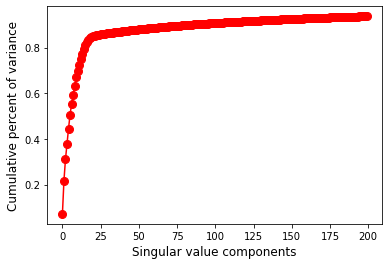

In [79]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD (n_components=200)
latent_matrix = svd.fit_transform(tfidf_df)
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color= 'red')
plt.xlabel('Singular value components', fontsize=12)
plt.ylabel('Cumulative percent of variance',fontsize=12)
plt.show()

In [80]:
n=200
latent_matrix_1_df= pd.DataFrame (latent_matrix[:,0:n], index=Final.title.tolist())

In [81]:
latent_matrix.shape

(9625, 200)

# creating a collaborative latent matrix from user ratings 

In [82]:
ratings_f.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [83]:
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on="movieId", how="right")


In [84]:
ratings_f2=ratings_f1.pivot(index='movieId',columns='userId',values='rating').fillna(0)

In [85]:
ratings_f2.head(3)

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [86]:
ratings_f2.shape

(9625, 364)

In [87]:
len(ratings_f.movieId.unique())

9625

In [90]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix_2=svd.fit_transform(ratings_f2)
latent_matrix_2_df=pd.DataFrame(latent_matrix_2,index=Final.title.tolist() )

In [91]:
latent_matrix_2_df.shape

(9625, 200)

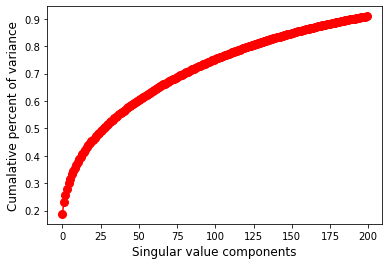

In [94]:
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained,'.-',ms=16,color='red')
plt.xlabel('Singular value components',fontsize=12)
plt.ylabel('Cumalative percent of variance',fontsize=12)
plt.show()

# Running a content/collabiritive and hybrid

In [99]:
from sklearn.metrics.pairwise import cosine_similarity
a_1 =np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1,-1)
a_2 =np.array(latent_matrix_2_df.loc['Toy Story (1995)']).reshape(1,-1)

score_1=cosine_similarity(latent_matrix_1_df,a_1).reshape(-1)
score_2=cosine_similarity(latent_matrix_2_df,a_2).reshape(-1)

hybrid=((score_1+score_2)/2.0)

dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid}
similar=pd.DataFrame(dictDf,index=latent_matrix_1_df.index)

similar.sort_values('hybrid',ascending=False,inplace=True)
similar[1:].head(11)

,content,collaborative,hybrid
"Bug's Life, A (1998)",0.888346,0.596212,0.742279
Toy Story 2 (1999),0.771571,0.688629,0.730100
"Monsters, Inc. (2001)",0.468821,0.606783,0.537802
Shrek (2001),0.398573,0.670362,0.534468
Up (2009),0.550351,0.425558,0.487954
Antz (1998),0.468821,0.441665,0.455243
Ice Age (2002),0.410659,0.481338,0.445998
Who Framed Roger Rabbit? (1988),0.387381,0.502588,0.444985
Aladdin (1992),0.257525,0.629910,0.443717
Toy Story 3 (2010),0.384135,0.502598,0.443366
